In [227]:
import gc
import numpy as np
from tqdm import tqdm
from datetime import datetime
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available() # You need to request a GPU from Runtime > Change Runtime Type
print(torch.__version__)

1.13.1+cu117


In [2]:
! ls ../../data/text_corpora/prepared/eng/

books.clean50.test
books.clean50.train
books_test.txt
books_train_small.txt
books_val_small.txt
toy_data.txt
trevor_sample.txt


In [344]:
file_path = "../../data/text_corpora/prepared/eng/toy_data.txt"
with open(file_path, 'r', encoding='utf-8') as f:
    file = f.read()
    char_set = set(file)
    char_set.remove("\n")
    lines = file.strip().lower().split('\n')
    del file
    gc.collect()
    
vocab = list(char_set)
vocab_size = len(vocab) + 3

In [345]:
PAD = 0
SOS = 1
EOS = 2

def generate_maps(vocab):
    char2index = {'<PAD>':PAD, '<SOS>':SOS, '<EOS>':EOS}
    index2char = {PAD:'<PAD>', SOS:'<SOS>', EOS:'<EOS>'}
    for i, w in enumerate(vocab):
        char2index[w] = i + 3
        index2char[i+3] = w
    return char2index, index2char

def sentence2index(s, _map):
    out = []
    for c in s:
        out.append(_map[c])
    return out

def index2sentence(ind, _map):
    out = []
    for i in ind:
        if i != 0:
            out.append(_map[i])
    return ''.join(out)

def convert_lines(lines, _map, max_len=62):
    out = []
    for line in lines:
        n = len(line)
        if n <= max_len:
            pad_len = max_len - n
            padding = [PAD] * pad_len
            out.append([SOS] + sentence2index(line, _map) + [EOS] + padding)
    return out

class TextDataset(Dataset):
    def __init__(self, data):
        super(TextDataset, self).__init__()
        self.data = data
    def __getitem__(self, index):
        return self.data[index]
    def __len__(self):
        return self.data.shape[0]
    
def ptensor2sentence(p, _map):
    ind = torch.argmax(p, dim=-1)
    return index2sentence(ind.cpu().numpy().tolist(), _map)

# def save_maps(char2index, index2char, name, map_dir="../../outputs/maps/"):
#     with open(map_dir + 'char2index_{}.json'.format(name), 'w') as json_file:
#         json.dump(char2index, json_file)
#     with open(map_dir + 'index2char_{}.json'.format(name), 'w') as json_file:
#         json.dump(index2char, json_file)
        
# def load_maps(name, map_dir="../../outputs/maps/"):
#     with open(map_dir + 'char2index_{}.json'.format(name), 'r') as json_file:
#         char2index = json.load(json_file)
#     with open(map_dir + 'index2char_{}.json'.format(name), 'r') as json_file:
#         index2word = json.load(json_file, object_hook=keys2int)
#     return char2index, index2char


In [346]:
char2index, index2char = generate_maps(vocab)
data = convert_lines(lines, char2index)
dataset = TextDataset(torch.LongTensor(data))
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [347]:
for batch in data_loader:
    s = index2sentence(batch[0].numpy().tolist(), index2char)
    print(s)
    break

<SOS>i 'd never do what tom did .<EOS>


In [348]:
z_dim = 64
class Generator(nn.Module):
    def __init__(self, vocab_size, input_size=64):
        super(Generator, self).__init__()
        self.F = 512
        self.num_layers = 5
        out_layer_depth = self.F // 2**self.num_layers
        self.linear = nn.Linear(input_size, self.F*2)
        self.upsample = nn.ModuleList(\
            nn.Upsample(scale_factor=2, 
            mode="nearest")
            for i in range(self.num_layers)
        )
        #self.pad = nn.ReflectionPad2d(1)
        self.convs = nn.ModuleList(nn.Conv1d(self.F//(2**i), 
                                             self.F//(2**(i+1)), 
                                             3, stride=1, padding=1) 
                                   for i in range(self.num_layers))
        self.bn = nn.ModuleList(nn.BatchNorm1d(self.F//(2**i)) for i in range(1, self.num_layers+1))
        
        self.proj = nn.Linear(out_layer_depth, vocab_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        
        b, _ = x.shape
        x = self.linear(x)
        x = x.reshape(b, self.F, 2)
        
        for i in range(5):
            x = self.upsample[i](x)
            x = self.relu(self.convs[i](x))
            x = self.bn[i](x)
        x = self.proj(x.transpose(1, 2))
        return F.softmax(x, dim=-1)
        print(x.shape)
        #x = self.sig(self.conv_out(x))
        #return x

torch.Size([8, 64, 41])
svvxvs,,vbvvvviwwibloovbbobwwwfff!!!ggpfffffff!f'lwöccllwwwww
,kqufffwccnwwaqqqqqааpúéééééxxxvvvvnvúvvvvvvvlvvvvvssvnnaa!r
<EOS>s'kkzcczckzzúúkc!!c !kkkfkffahaaaalllaaaa!,,aaaaallllkh'<EOS>av
,,,,,!!!!.vvvvçvvvvvjjmvsffzzzzffqffzekepeekkkh!!!hhh""bbbrrrwl
!.s.ssrwwuuféhpuuuuueuuffuhhhéuuujjéq  n  aqfm m mvvvaas
bbvaaa!!!liwwwww!!!!cfuuupbbokmúçwwúúffkpkhhhaawwwwwwwccuv,r,,,n
abkk accccqaqúúcaaanqééqqqqqqqqqqqqddqaaqqaa!p!púúúúúú
!wr'..wwwwwww..ww....wwéuééuuééééjnééé?????ccprbbbbmkakkkka!z


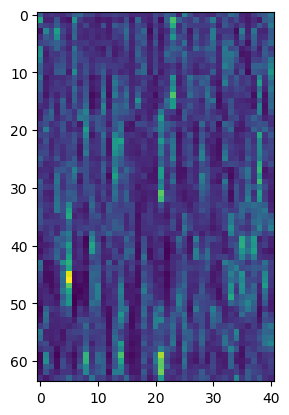

In [349]:
z = torch.randn(8, 64)
G = Generator(vocab_size)
out = G(z)
print(out.shape)
for yi in out:
    print(ptensor2sentence(yi, index2char))
plt.imshow(out[0].detach().numpy())
plt.show()

In [328]:
class Discriminator(nn.Module):
    def __init__(self, vocab_size):
        super(Discriminator, self).__init__()

        #self.embedder = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        self.conv1 = nn.Conv1d(vocab_size, 16, kernel_size=3, stride=1, padding=1)
        self.dsample1 = nn.Conv1d(16, 16, kernel_size=2, stride=2)
        
        self.bn2 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.dsample2 = nn.Conv1d(32, 32, kernel_size=2, stride=2)
        
        self.bn3 = nn.BatchNorm1d(32)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.dsample3 = nn.Conv1d(64, 64, kernel_size=2, stride=2)
        
        self.bn4 = nn.BatchNorm1d(64)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.dsample4 = nn.Conv1d(128, 128, kernel_size=2, stride=2)

        self.bn5 = nn.BatchNorm1d(128)
        self.conv5 = nn.Conv1d(128, 64, kernel_size=3, stride=1, padding=1)
        self.dsample5 = nn.Conv1d(64, 1, kernel_size=2, stride=2)

        self.fc = nn.Linear(2, 1)
        self.relu = nn.ReLU()
        self.leaky = nn.LeakyReLU(negative_slope=0.2)
    
    def forward(self, x):
        b,_,_ = x.shape
        #x = self.embedder(x)
        
        layer1 = self.relu(self.conv1(x.transpose(1, 2)))
        layer1 = self.dsample1(layer1)

        layer2 = self.conv2(self.bn2(layer1))
        layer2 = self.dsample2(self.leaky(layer2))

        layer3 = self.conv3(self.bn3(layer2))
        layer3 = self.dsample3(self.leaky(layer3))

        layer4 = self.conv4(self.bn4(layer3))
        layer4 = self.dsample4(self.leaky(layer4))

        layer5 = self.conv5(self.bn5(layer4))
        layer5 = self.dsample5(self.leaky(layer5))
        
        out = self.fc(layer5.reshape(b, -1))
        return out
    

In [329]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        
    def forward(self, x):
        smooth_dist = torch.zeros(*x.shape, self.size, device=x.device, dtype=torch.float)
        smooth_dist.fill_(self.smoothing / (self.size - 2))
        smooth_dist.scatter_(2, x.unsqueeze(2), self.confidence)
        smooth_dist[:, :, self.padding_idx] = 0
        mask = (x == self.padding_idx).unsqueeze(-1)
        smooth_dist = smooth_dist.masked_fill(mask, 0.0)
        return smooth_dist
    
def mask_probs(x, sos_id=SOS, eos_id=EOS, pad_id=PAD):
    """
    x: [batch, seq_len, vocab] probability distribution over vocab
    """
    # Get predicted tokens
    preds = x.argmax(dim=-1)  # [batch, seq_len]

    # Initialize mask (True = keep, False = zero out)
    mask = torch.ones_like(preds, dtype=torch.bool)

    for b in range(preds.size(0)):
        seq = preds[b]

        # Find SOS position
        sos_pos = (seq == sos_id).nonzero(as_tuple=True)[0]
        if len(sos_pos) > 0:
            sos_pos = sos_pos[0].item()
            mask[b, :sos_pos] = False  # zero out before SOS

        # Find EOS position
        eos_pos = (seq == eos_id).nonzero(as_tuple=True)[0]
        if len(eos_pos) > 0:
            eos_pos = eos_pos[0].item()
            mask[b, eos_pos+1:] = False  # zero out after EOS

        # Mask PAD tokens
        mask[b, seq == pad_id] = False

    # Expand mask to [batch, seq_len, vocab]
    mask = mask.unsqueeze(-1).expand_as(x)

    # Apply mask
    return x * mask.float()

In [350]:
b, s, v = 2, 6, 5
x = torch.rand(b, s, v)
x = x / x.sum(-1, keepdim=True)  # normalize so probs sum to 1

masked = mask_probs(x)

print("Original preds:", x.argmax(-1))
print("Masked shape:", masked.shape)

Original preds: tensor([[0, 3, 0, 4, 0, 0],
        [0, 1, 0, 0, 2, 2]])
Masked shape: torch.Size([2, 6, 5])


In [352]:
D = Discriminator(vocab_size)
smoothing = LabelSmoothing(vocab_size, 0, smoothing=0.1)
print(smoothing(batch).shape)
out = D(smoothing(batch))
out.shape
z = torch.randn(8, 64)
G = Generator(vocab_size)
y = G(z)
out = D(mask_probs(y))
print(out.shape)

torch.Size([64, 64, 41])
torch.Size([8, 1])


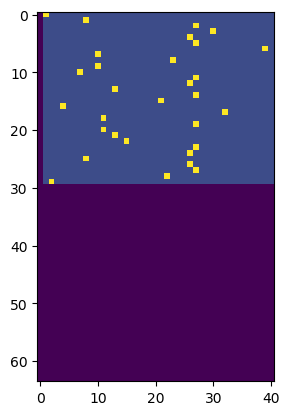

In [353]:
smoothing = LabelSmoothing(vocab_size, 0, smoothing=0.9)
smooth_dist = smoothing(batch)
plt.imshow(smooth_dist[0])
plt.show()

In [ ]:
beta1 = 0.98
beta2 = 0.9
lmda = 10
n_critic = 3
lr = .0005
batch_size=64
d_embed = 8

In [355]:
class WGAN_gloss(nn.Module):
    def __init__(self):
        super(WGAN_gloss, self).__init__()

    def forward(self, G, D, z):
        return -D(mask_probs(G(z)))

class WGAN_dloss(nn.Module):
    def __init__(self):
        super(WGAN_dloss, self).__init__()
        self.smoothing = LabelSmoothing(vocab_size, PAD, smoothing=0.1)

    def forward(self, G, D, x, z, eps, lmda):
        y = mask_probs(G(z))
        x = self.smoothing(x)
        x_hat = eps*x + (1-eps)*y
        x_hat = x_hat.requires_grad_()
        confidence = D(x_hat).mean()
        grad = torch.autograd.grad(confidence, x_hat, create_graph=True)[0]
        L = lmda * (torch.norm(grad, 2) - 1)**2
        loss = D(y) - D(x) + L
        return loss


In [356]:
def save_model(G, D, G_optim, D_optim, z_test, texts):
    timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M")
    model_name = "gan_text_" + timestamp

    state = {
      'gen_model': G.state_dict(),
      'disc_model': D.state_dict(),
      'gen_optim': G_optim.state_dict(),
      'disc_optim': D_optim.state_dict(),
      'z_test': z_test
    }
    torch.save(state, 'output/model/{}.pt'.format(model_name))
    torch.save({
      'texts': texts
    }, 'output/generated/text_{}.pt'.format(model_name))

def load_model(model_name):
    G = Generator(vocab_size)
    G = G.cuda()
    D = Discriminator(vocab_size)
    D = D.cuda()
    G_optim = optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
    D_optim = optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))

    checkpoint = torch.load('output/model/{}.pt'.format(model_name))
    G.load_state_dict(checkpoint['gen_model'])
    D.load_state_dict(checkpoint['disc_model'])
    G_optim.load_state_dict(checkpoint['gen_optim'])
    D_optim.load_state_dict(checkpoint['disc_optim'])
    z_test = checkpoint['z_test']

    return G, D, G_optim, D_optim, z_test

def make_model():
    G = Generator(vocab_size)
    G = G.cuda()
    D = Discriminator(vocab_size)
    D = D.cuda()
    G_optim = optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
    D_optim = optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))
    z_test = torch.randn(8, z_dim).cuda()
    return G, D, G_optim, D_optim, z_test

In [307]:
G, D, G_optim, D_optim, z_test = make_model()
G_obj = WGAN_gloss()
D_obj = WGAN_dloss()

for batch in data_loader:
    x = batch.cuda()
    z = torch.randn(batch_size, z_dim).cuda()
    eps = np.random.uniform(0,1)
    dloss = D_obj(G, D, x, z, eps, lmda).mean()
    dloss.backward()
    D_optim.step()
    print(dloss)
    x = batch.cuda()
    z = torch.randn(batch_size, z_dim).cuda()
    gloss = G_obj(G, D, z).mean()
    gloss.backward()
    G_optim.step()
    print(gloss)
    break

tensor(5.4024, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5311, device='cuda:0', grad_fn=<MeanBackward0>)


In [287]:
del G, D, G_optim, D_optim, z_test, G_obj, D_obj
gc.collect()
torch.cuda.empty_cache()

In [ ]:
def scope(dataset, G, D, G_optim, D_optim, z_test):
    try:
        gc.collect()
        torch.cuda.empty_cache()
        print(torch.cuda.memory_allocated(0) / 1e9)
        
        epochs = range(10)
        G_obj = WGAN_gloss()
        D_obj = WGAN_dloss()
        test_texts = []
        for e in epochs:
            loop = tqdm(total=len(data_loader), position=0, leave=False)
            for i, batch in enumerate(data_loader):
                try:
                    #train discriminator
                    #because you want to be able to backprop through the params in discriminator 
                    for p in D.parameters():
                        p.requires_grad = True

                    for p in G.parameters():
                        p.requires_grad = False

                    for n in range(n_critic):
                        D_optim.zero_grad()

                        # generate noise tensor z
                        # calculate disc loss: you will need autograd.grad
                        # call dloss.backward() and disc_optim.step()
                        x = batch.cuda()
                        z = torch.randn(batch_size, z_dim).cuda()
                        eps = np.random.uniform(0,1)
                        dloss = D_obj(G, D, x, z, eps, lmda).mean()
                        dloss.backward()
                        D_optim.step()

                    #train generator
                    for p in D.parameters():
                        p.requires_grad = False

                    for p in G.parameters():
                        p.requires_grad = True

                    G_optim.zero_grad()
                    # generate noise tensor z
                    # calculate loss for G
                    # call gloss.backward() and G_optim.step()
                    x = batch.cuda()
                    z = torch.randn(batch_size, z_dim).cuda()
                    gloss = G_obj(G, D, z).mean()
                    gloss.backward()
                    G_optim.step()
                    loop.set_description('epoch:{}, dloss:{:.4f}, gloss:{:.3f}'.format(e, dloss.item(), gloss.item()))
                    loop.update(1)
                    if i % 1000 == 0:
                        y = mask_probs(G(z_test))
                        y = y.detach().cpu()
                        for yi in y:
                            print(ptensor2sentence(yi, index2char))
                        print()
                        test_texts.append(y)
                except RuntimeError:
                    continue
    except:
        __ITB__()
    finally:
        y = G(z_test)
        y = y.detach().cpu()
        for yi in y:
            print(ptensor2sentence(yi, index2char))
        test_texts.append(y)
        save_model(G, D, G_optim, D_optim, z_test, test_texts)
        print("Training session has ended or terminated.")

#G, D, G_optim, D_optim, z_test = load_model("gan_text_2025-09-26-21-50")
G, D, G_optim, D_optim, z_test = make_model()

scope(data_loader, G, D, G_optim, D_optim, z_test)

In [ ]:
G, D, G_optim, D_optim, z_test = load_model("gan_text_2025-09-27-04-44")

In [368]:
history1 = torch.load("output/generated/text_gan_text_2025-09-26-21-50.pt")
history2 = torch.load("output/generated/text_gan_text_2025-09-27-04-44.pt")
z_text_history = history1['texts'] + history2['texts']

In [377]:
for p in z_text_history[-4]:
    print(ptensor2sentence(p, index2char))

ldoursd o ami <EOS>
<SOS>ie 'ow hy 'rd ti'g ,s d mo ns .<EOS>
<SOS>ioo ve t an  <EOS>
<SOS>doa' hn  nntetvf tob  <EOS>
<SOS>i woidd  ene llle tll t<EOS>
<SOS>me ai hhetandhd ttd t tolgoa ?.hdén nrshhrv tfll vié<EOS>
<SOS>ie 'owhhyd're vi'g usmdieo ns .<EOS>
'toe h  t  nndonnd vfalens .oh  hhaaa aa aa hag .. . ?.<EOS>
